In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic
plt.rc('font', family='NanumBarunGothic')

plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지

pd.set_option('display.max_columns', None)                       # 출력할 열의 최대개수
pd.set_option('display.max_colwidth', None)                      # 출력할 열의 너비
# pd.reset_option('display.max_rows', None)                    # 출력할 행의 최대개수  None
pd.set_option('display.unicode.east_asian_width', True) 

In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
random_seed = 1106
set_random_seed(random_seed)

### 컬럼 설명
### train_users_2.csv
- id : 사용자 아이디
- date_account_created: 계정 생성 날짜
- timestamp_first_active: 첫 번째 활동의 타임스탬프입니다. 사용자가 가입하기 전에 검색할 수 있으므로 date_account_created 또는 date_first_booking보다 이전일 수 있습니다.
- date_first_booking: 첫 예약 날짜
- 성별
- 나이
- signup_method - 가입_방법
- signup_flow: 사용자가 가입하기 위해 온 페이지
- language: 국제 언어 기본 설정
- affili_channel: 유료 마케팅의 종류
- affiliate_provider: 마케팅이 이루어지는 곳. 구글, 크레이그리스트, 기타
- first_affiliate_tracked: 가입하기 전에 사용자가 처음으로 상호작용한 마케팅은 무엇입니까?
- signup_app - 가입_앱
- first_device_type - 첫 번째_장치_유형
- first_browser - 첫 번째_브라우저
- country_destination: 예측할 대상 변수입니다.
### session.csv - 사용자에 대한 웹 세션 로그
- user_id: users 테이블의 'id' 컬럼과 조인됩니다.
- action - 행동 
- action_type
- action_detail - 액션_디테일
- device_type - 기기 종류
- secs_elapsed - 초_경과 
#### country.csv - 이 데이터세트의 목적지 국가와 해당 위치에 대한 요약 통계
#### age_gender_bkts.csv - 사용자의 연령대, 성별, 목적지 국가에 대한 요약 통계
#### Sample_submission.csv - 예측 제출을 위한 올바른 형식

## 데이터 로드 

In [3]:
train = pd.read_csv("train_users_2.csv") ## 학습 데이터
sessions = pd.read_csv("sessions.csv") ## 유저 세션 데이터
test = pd.read_csv("test_users.csv") ## 테스트 데이터

train.rename(columns={'id':'user_id'}, inplace=True)

### user_flow 생성

In [4]:
sessions['user_flow'] = sessions['action'].astype('str') + '+' + sessions['action_type'].astype('str') + '+' + sessions['action_detail'].astype('str')

### timestamp_first_active ->  datetime 타입 변환

In [5]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d')
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'])
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

### train, session에 공통 id로 train 구성 -> session 조인 X

In [6]:
# train의 user_id가 sessions의 user_id에 포함되어 있는지 판단
mask = train['user_id'].isin(sessions['user_id'])

## sessions에 포함된 user로 구성 (중복 x)
df = train[mask]
df.reset_index(drop=True, inplace=True)

In [7]:
df

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,d1mm9tcy42,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,yo8nz8bqcq,2014-01-01,2014-01-01,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
2,4grx6yxeby,2014-01-01,2014-01-01,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF
3,ncf87guaf0,2014-01-01,2014-01-01,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
4,4rvqpxoh3h,2014-01-01,2014-01-01,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,zxodksqpep,2014-06-30,2014-06-30,NaT,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
73811,mhewnxesx9,2014-06-30,2014-06-30,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
73812,6o3arsjbb4,2014-06-30,2014-06-30,NaT,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
73813,jh95kwisub,2014-06-30,2014-06-30,NaT,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73815 entries, 0 to 73814
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  73815 non-null  object        
 1   date_account_created     73815 non-null  datetime64[ns]
 2   timestamp_first_active   73815 non-null  datetime64[ns]
 3   date_first_booking       28774 non-null  datetime64[ns]
 4   gender                   73815 non-null  object        
 5   age                      41567 non-null  float64       
 6   signup_method            73815 non-null  object        
 7   signup_flow              73815 non-null  int64         
 8   language                 73815 non-null  object        
 9   affiliate_channel        73815 non-null  object        
 10  affiliate_provider       73815 non-null  object        
 11  first_affiliate_tracked  73513 non-null  object        
 12  signup_app               73815 n

In [9]:
df.isnull().sum()

user_id                        0
date_account_created           0
timestamp_first_active         0
date_first_booking         45041
gender                         0
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [10]:
df.describe()

,age,signup_flow
count,41567.000000,73815.000000
mean,42.414993,4.856208
std,111.201954,9.339480
min,1.000000,0.000000
25%,27.000000,0.000000
50%,32.000000,0.000000
75%,41.000000,0.000000
max,2014.000000,25.000000


In [11]:
df.describe(include='object')

,user_id,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,73815,73815,73815,73815,73815,73815,73513,73815,73815,73815,73815
unique,73815,4,3,24,8,17,7,4,9,35,12
top,d1mm9tcy42,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,1,37788,55135,71100,46814,46814,39049,57016,28029,22662,45041


- 클래스 불균형을 고려해야 됨

In [12]:
# counts = df['country_destination'].value_counts()
# idx = df['country_destination'].value_counts().index

# sns.barplot(x=idx,  y=counts, hue=idx)

# plt.title("국가별 예약 빈도")
# plt.show()

In [13]:
# order = df['country_destination'].value_counts().index
# object_col = df.describe(include='object').columns[1:]

# for col in object_col:     
#     stacked_df = df.groupby([col, 'country_destination']).size().unstack(fill_value=0)[order]
#     ax = stacked_df.plot(kind='bar', stacked=True, cmap='tab20')
#     ax.legend(title='Country Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(col)
    
# plt.tight_layout()
# plt.show()

# session 변수 고려

In [14]:
# 한 칸씩 위로 당겨오기
sessions['secs_elapsed'] = sessions['secs_elapsed'].shift(-1)

# 유저별 마지막 elapsed time은 측정되지 않았으므로 nan
last_order = sessions.groupby('user_id').tail(1).index
sessions.loc[last_order, 'secs_elapsed'] = np.NaN

In [15]:
sessions_flow_counts = sessions.groupby('user_id')['user_flow'].size().reset_index()
sessions_flow_counts.columns = ['user_id', 'user_flow_counts']
sessions_flow_counts

,user_id,user_flow_counts
0,00023iyk9l,40
1,0010k6l0om,63
2,001wyh0pz8,90
3,0028jgx1x1,31
4,002qnbzfs5,789
...,...,...
135478,zzxox7jnrx,89
135479,zzy7t0y9cm,8
135480,zzysuoqg6x,3
135481,zzywmcn0jv,51


In [16]:
# train의 user_id가 sessions의 user_id에 포함되어 있는지 판단
mask = sessions['user_id'].isin(train['user_id'])

## sessions에 포함된 user로 구성 (중복 x)
new_sessions = sessions[mask]
new_sessions.reset_index(drop=True, inplace=True)

In [17]:
new_sessions_flow_counts = new_sessions.groupby('user_id')['user_flow'].size().reset_index()
new_sessions_flow_counts.columns = ['user_id', 'user_flow_counts']
new_sessions_flow_counts

,user_id,user_flow_counts
0,00023iyk9l,40
1,001wyh0pz8,90
2,0028jgx1x1,31
3,002qnbzfs5,789
4,0035hobuyj,489
...,...,...
73810,zzx5wp3lqu,52
73811,zzy7t0y9cm,8
73812,zzysuoqg6x,3
73813,zzywmcn0jv,51


## 데이터 전처리

In [18]:
df.isnull().sum()

user_id                        0
date_account_created           0
timestamp_first_active         0
date_first_booking         45041
gender                         0
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

### age 전처리

In [19]:
## 전처리 전
df['age'].describe()

count    41567.000000
mean        42.414993
std        111.201954
min          1.000000
25%         27.000000
50%         32.000000
75%         41.000000
max       2014.000000
Name: age, dtype: float64

- test 데이터에도 결측치가 존재하기 때문에 age를 제거하는 방식은 알맞지 않다. 
- 따라서 이상치도 최빈값으로 대체.

In [20]:
# 1000이상인 값은 태어난 년도로 간주하여 계정 생성연도를 추출하여 나이를 채운다
current_year = pd.to_datetime(df['date_account_created']).dt.year
birth_year = current_year - df['age']
df['age'] = np.where(df['age'] > 1000, np.where(birth_year > 0, birth_year, 0), df['age'])

## 결측치는 최빈값으로 대체
mode_age = df['age'].mode()[0]  
df['age'].fillna(mode_age, inplace=True)  

## 18세 초과는 최빈값
df['age'] = df['age'].apply(lambda x: mode_age if x > 100 else x)

## 100세 초과는 최빈값
df['age'] = df['age'].apply(lambda x: mode_age if x < 18 else x)

In [21]:
## 전처리 후
df['age'].describe()

count    73815.000000
mean        31.563056
std          9.593033
min         18.000000
25%         27.000000
50%         27.000000
75%         33.000000
max        100.000000
Name: age, dtype: float64

In [22]:
print(len(df[df['age'] > 100]))
print(len(df[df['age'] < 18]))

0
0


In [ ]:
# counts = new_df['age'].value_counts()
# idx = new_df['age'].value_counts().index

# plt.figure(figsize=(10, 6))

# sns.barplot(x=idx,  y=counts)

# plt.title("나이 분포 -- 전처리 0")
# plt.xticks(rotation=90, ha='right')
# plt.show()

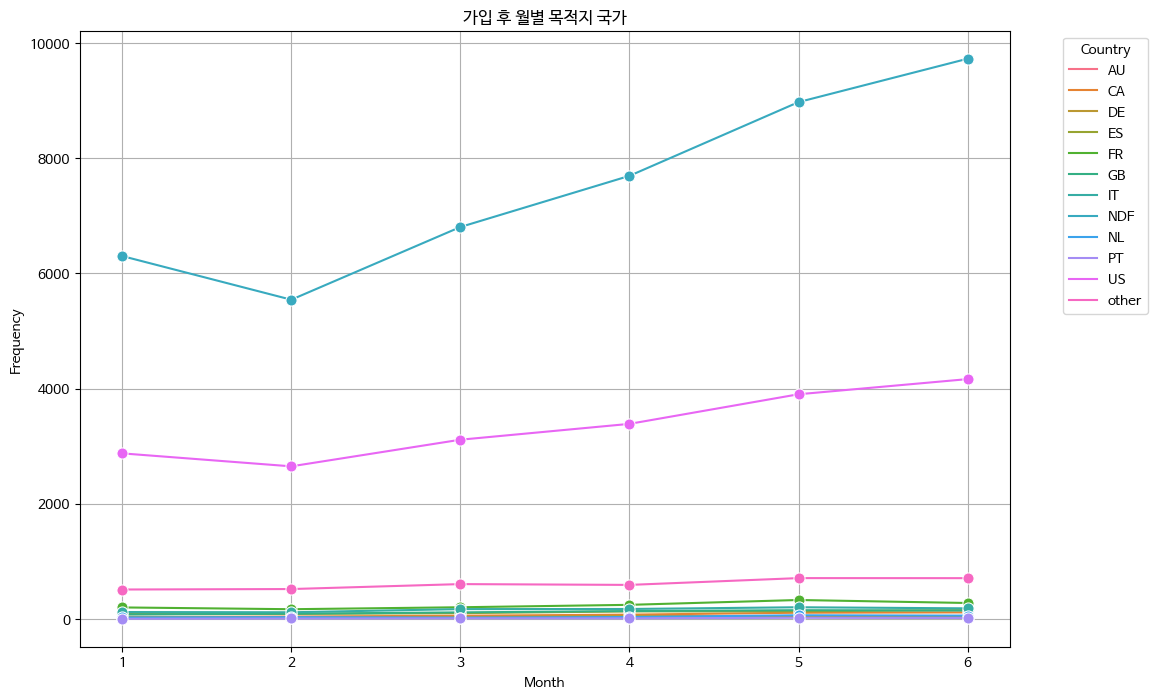

In [24]:
###### 
month = pd.to_datetime(df['date_account_created']).dt.month
country_destination = df['country_destination']

# DataFrame 생성
data = pd.DataFrame({'Month': month, 'Country': country_destination})

# 목적 국가와 월별 빈도 계산
country_month_counts = data.groupby(['Country', 'Month']).size().reset_index(name='Frequency')

# 월별 그래프 그리기
plt.figure(figsize=(12, 8))
sns.lineplot(data=country_month_counts, x='Month', y='Frequency', hue='Country', marker='o', markersize=8)
plt.title('가입 후 월별 목적지 국가')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))  # 1월부터 6월
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

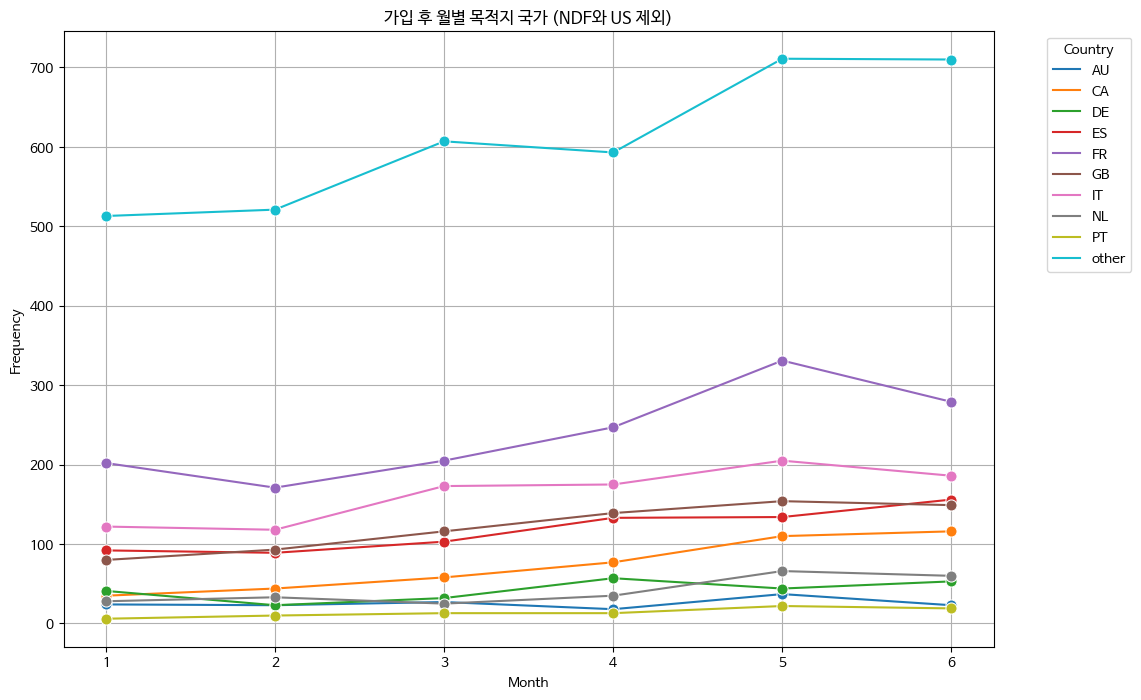

In [25]:
# 데이터 준비
month = pd.to_datetime(df['date_account_created']).dt.month
country_destination = df['country_destination']

# DataFrame 생성
data = pd.DataFrame({'Month': month, 'Country': country_destination})

# NDF와 US 국가 제외
data = data[~data['Country'].isin(['NDF', 'US'])]

# 목적 국가와 월별 빈도 계산
country_month_counts = data.groupby(['Country', 'Month']).size().reset_index(name='Frequency')

# 월별 그래프 그리기
plt.figure(figsize=(12, 8))
sns.lineplot(data=country_month_counts, x='Month', y='Frequency', hue='Country', marker='o', markersize=8)
plt.title('가입 후 월별 목적지 국가 (NDF와 US 제외)')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))  # 1월부터 6월
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### 데이터 클러스터링 

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
le = LabelEncoder()
ss = StandardScaler()

In [27]:
ss_new_df = df.copy()

## 불필요한 데이터 및 정답 데이터는 제거
ss_new_df = ss_new_df.drop(columns=['user_id','date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'])
ss_new_df['first_affiliate_tracked'].fillna("unknown",inplace=True)

cols = ss_new_df.select_dtypes(exclude='object').columns
ss_new_df[cols] = ss.fit_transform(ss_new_df[cols])

In [28]:
# getting categorical columns and their indices.
catColumnsPos = [ss_new_df.columns.get_loc(col) for col in list(ss_new_df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(ss_new_df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
Categorical columns position  : [0, 2, 4, 5, 6, 7, 8, 9, 10]


In [30]:
from kmodes.kprototypes import KPrototypes

dfMatrix = ss_new_df.to_numpy()

In [31]:
cost = []
for x in range(2,6):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = x, init = 'Huang', random_state = random_seed)
    clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(clusters))

Cluster initiation: [0 0 0 ... 0 1 1]
Cluster initiation: [2 0 0 ... 0 1 1]
Cluster initiation: [0 1 3 ... 1 2 2]
Cluster initiation: [2 4 3 ... 4 0 0]


In [32]:
df_cost = pd.DataFrame()
df_cost['clusters'] = range(2, 6)
df_cost['cost'] = cost

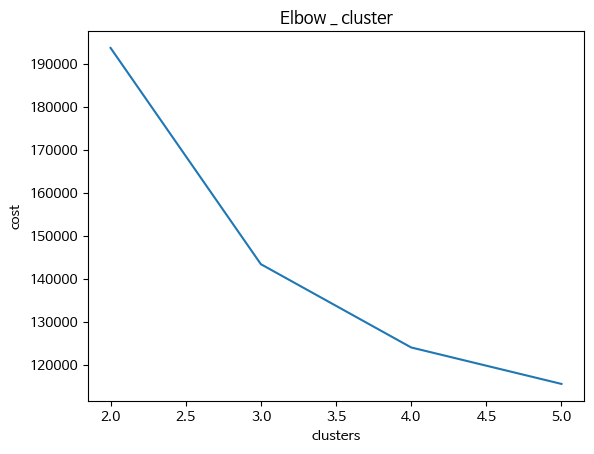

In [33]:
# elbow method 
sns.lineplot(x='clusters', y= 'cost', data=df_cost)
plt.title("Elbow _ cluster")
plt.show()

In [42]:
# Kmeans tuned
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = random_seed)
clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

In [43]:
ss_new_df['clusters'] = clusters

In [44]:
df['clusters'] = clusters

In [37]:
# counts = new_df['country_destination'].value_counts()
# idx = new_df['country_destination'].value_counts().index

# sns.barplot(x=idx,  y=counts, hue=idx)

# plt.title("국가별 예약 빈도")
# plt.show()

In [ ]:
# plt.figure(figsize=(12,6))

# sns.scatterplot(x ='age',
#                     y = 'signup_flow',
#                     data = ss_new_df,
#                     hue='clusters',
#                    palette = 'Set2')
# plt.show()

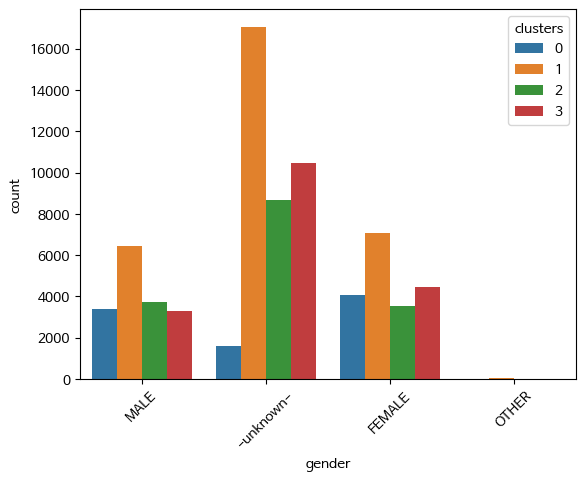

In [45]:
sns.countplot(data=df, x='gender', hue='clusters')
plt.xticks(rotation=45) 
plt.show()

In [46]:
# order = new_df['country_destination'].value_counts().index
# object_col = new_df.describe(include='object').columns[1:]

# for col in object_col:     
#     stacked_df = new_df.groupby([col, 'country_destination']).size().unstack(fill_value=0)[order]
#     ax = stacked_df.plot(kind='bar', stacked=True, cmap='tab20')
#     ax.legend(title='Country Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(col)
    
# plt.tight_layout()
# plt.show()

In [47]:
df.isnull().sum()

user_id                        0
date_account_created           0
timestamp_first_active         0
date_first_booking         45041
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
clusters                       0
dtype: int64

In [48]:
df['first_affiliate_tracked'].fillna("unknown",inplace=True)

In [49]:
df.describe()

,age,signup_flow,clusters
count,73815.000000,73815.000000,73815.000000
mean,31.563056,4.856208,1.587496
std,9.593033,9.339480,0.990667
min,18.000000,0.000000,0.000000
25%,27.000000,0.000000,1.000000
50%,27.000000,0.000000,1.000000
75%,33.000000,0.000000,2.000000
max,100.000000,25.000000,3.000000


### 수치형 변수 log 변환 스케일링

In [50]:
### Train 데이터 전처리
df['age'] = np.log1p(df['age'])

### Train 데이터 전처리
df['signup_flow'] = np.log1p(df['signup_flow'])

In [51]:
df.describe()

,age,signup_flow,clusters
count,73815.000000,73815.000000,73815.000000
mean,3.449994,0.696125,1.587496
std,0.242448,1.293716,0.990667
min,2.944439,0.000000,0.000000
25%,3.332205,0.000000,1.000000
50%,3.332205,0.000000,1.000000
75%,3.526361,0.000000,2.000000
max,4.615121,3.258097,3.000000


# 클러스터링 추가

### 데이터 분리 - Hold_out

In [54]:
## 정답
target = df['country_destination']

## 학습에 사용하지 않은 변수 삭제
X = df.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'] , axis=1)

In [55]:
categorical_features = [
"gender",
"signup_method",
"language",
"affiliate_channel",
"affiliate_provider",
"first_affiliate_tracked",
"signup_app",
"first_device_type",
"first_browser"
]

# "date_account_created",
# "timestamp_first_active",

for i in categorical_features:
    X[i] = X[i].astype('category')
    # test[i] = test[i].astype('category')

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# ## 학습용 데이터 분할
# x_train, x_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2, shuffle=True, random_state=1106)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1106)

# 학습 및 검증 데이터 분할
for train_index, valid_index in sss.split(X, target):
    x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

# 결과 확인
print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_valid.shape, y_valid.shape)

Training set: (59052, 12) (59052,)
Validation set: (14763, 12) (14763,)


In [57]:
# pd.DataFrame(target).value_counts()

In [58]:
# pd.DataFrame(y_train).value_counts()

In [59]:
# pd.DataFrame(y_valid).value_counts()

In [60]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

# 학습 데이터에 대해 레이블 인코딩 적용
y_train_encoded = encoder.fit_transform(y_train)

# 검증 데이터에 대해서도 동일하게 레이블 인코딩 적용 (fit 메서드 사용 X)
y_valid_encoded = encoder.transform(y_valid)

## 모델 구축 및 학습

In [61]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import time

### 모델 평가 방식

In [62]:
def ndcg_accuracy(y_true, y_pred_proba):
    # NDCG 점수 계산
    ndcg = ndcg_score(y_true, pred_proba, k=5) ## 상위 5개
    return ndcg

## 모델 학습

In [63]:
# 모델 생성
model = CatBoostClassifier(
    iterations=100,
    cat_features=categorical_features,
    learning_rate=0.01,
    depth=6, 
    loss_function='MultiClass',  # 다중 분류 손실 함수 지정
    eval_metric='MultiClass',    # 다중 분류 평가 메트릭 지정
    verbose=False, 
    random_seed=random_seed
)

# 모델 학습
model.fit(x_train, y_train)

# 모델 예측
pred = model.predict(x_valid)

# 모델 국가 예측 확률
pred_proba = model.predict_proba(x_valid)

### 학습 결과

In [64]:
# Accuracy 계산
accuracy = accuracy_score(y_valid, pred)
print("Accuracy: {:.4f}".format(accuracy))

# F1 score 계산
f1 = f1_score(y_valid, pred, average='weighted')
print("F1 Score: {:.4f}".format(f1))

Accuracy: 0.6501
F1 Score: 0.6030


## 모델 평가 NDCG

In [65]:
# NDCG 점수 계산
ndcg = ndcg_accuracy(y_valid_encoded, pred_proba)
print("NDCG: {:.4f}".format(ndcg))

NDCG: 0.8348


In [66]:
# Confusion Matrix 계산
conf_matrix = confusion_matrix(y_valid, pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[   0    0    0    0    0    0    0   14    0    0   17    0]
 [   0    0    0    0    0    0    0   45    0    0   43    0]
 [   0    0    0    0    0    0    0   18    0    0   32    0]
 [   0    0    0    0    0    0    0   84    0    0   57    0]
 [   0    0    0    0    0    0    0  170    0    0  117    0]
 [   0    0    0    0    0    0    0   73    0    0   73    0]
 [   0    0    0    0    0    0    0  117    0    0   79    0]
 [   0    0    0    0    0    0    0 7740    0    0 1268    0]
 [   0    0    0    0    0    0    0   21    0    0   28    0]
 [   0    0    0    0    0    0    0   11    0    0    6    0]
 [   0    0    0    0    0    0    0 2161    0    0 1858    0]
 [   0    0    0    0    0    0    0  416    0    0  315    0]]


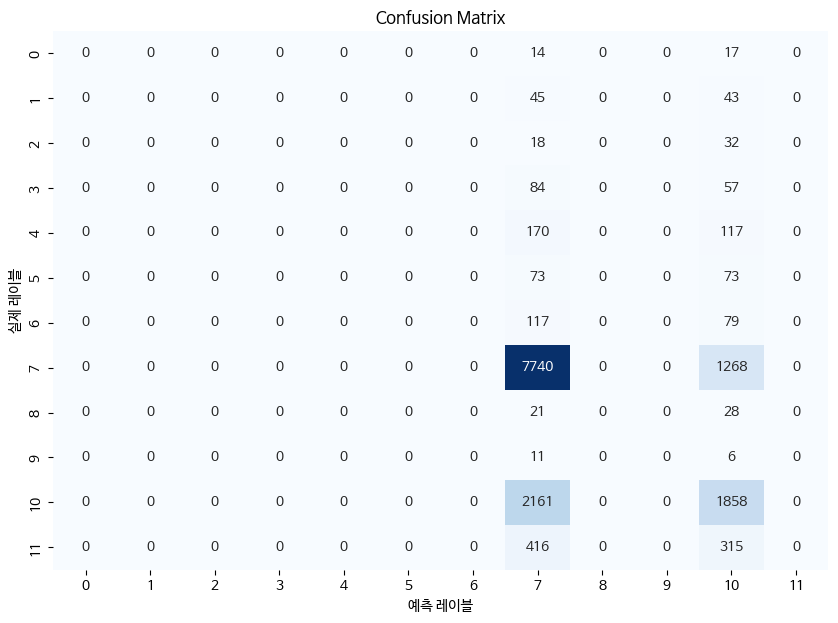

In [67]:
plt.figure(figsize=(10, 7))  # 시각화 크기 설정
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('예측 레이블')
plt.ylabel('실제 레이블')
plt.title('Confusion Matrix')
plt.show()

### 중요 feature

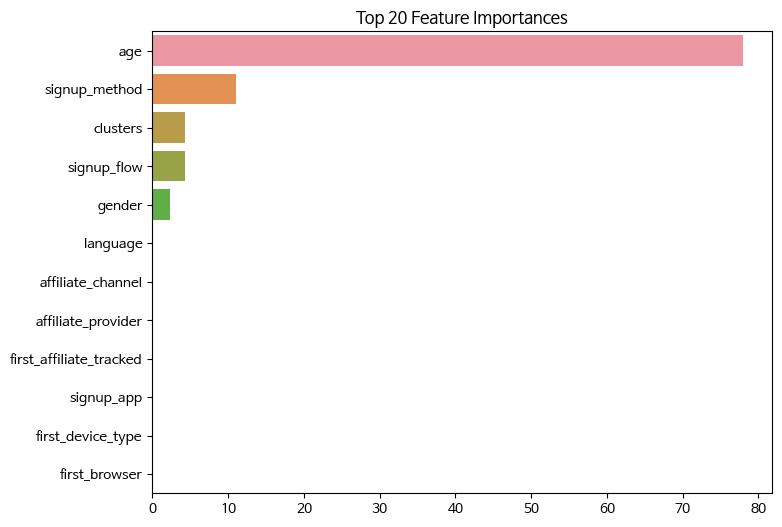

In [68]:
%matplotlib inline

ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# StratifiedKFold 사용

In [69]:
# StratifiedKFold 사용
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=300, 
                           learning_rate=0.01, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=categorical_features,
                           random_seed=random_seed,
                           auto_class_weights='Balanced', ## 클래스 불균형
                           verbose=0)

ndcg_scores = []

for train_index, test_index in skf.split(X, target):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(encoder.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

Mean NDCG Score: 0.6239838916265353


In [70]:
# StratifiedKFold 사용
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=300, 
                           learning_rate=0.01, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=categorical_features,
                           random_seed=random_seed,
                           verbose=0)

ndcg_scores = []

for train_index, test_index in skf.split(X, target):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(encoder.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

Mean NDCG Score: 0.8460268643556695
